# Miller age

In [1]:
1

1

In [1]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: True


In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [170]:
ood_seed = 32
num_ood = 1

In [171]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "dataset_complete_Miller.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["age"] = adata.obs["age"].astype("str").astype("category")

adata.obs["age"] = adata.obs["age"].astype("str").astype("category")
adata.obs["age_continuous"] = adata.obs["age"].astype(float)
df = adata.obs.groupby(["cell_type", "age"]).size()
df2 = adata.obs.groupby(["cell_type"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 350]

In [172]:
availables

[(('Bud tip adjacent cells', '15.0'), 282),
 (('Bud tip adjacent cells', '18.0'), 777),
 (('Bud tip progenitor', '11.5'), 273),
 (('Bud tip progenitor', '15.0'), 338),
 (('Bud tip progenitor', '18.0'), 683),
 (('Hub cells', '11.5'), 218),
 (('Hub cells', '15.0'), 308),
 (('Hub cells', '18.0'), 620),
 (('Lung ciliated cells', '15.0'), 692),
 (('Lung ciliated cells', '18.0'), 494),
 (('Lung secretory cells', '15.0'), 595),
 (('Lung secretory cells', '21.0'), 438),
 (('Submucosal gland cells', '15.0'), 380)]

In [173]:
availables = [
 (('Bud tip adjacent cells', '15.0'), 282),
 (('Bud tip adjacent cells', '11.5'), 282),
 (('Bud tip progenitor', '11.5'), 683),
 (('Bud tip progenitor', '15.0'), 683),
 (('Bud tip progenitor', '18.0'), 683),
 (('Hub cells', '11.5'), 683),
 (('Hub cells', '15.0'), 683),
 (('Lung ciliated cells', '15.0'), 683),
 (('Lung ciliated cells', '18.0'), 683),
]

In [174]:
def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    choices = [availables[i] for i in random_choices]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["cell_type"] == choice[0][0]) & (adata.obs["age"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

(('Lung ciliated cells', '15.0'), 683)

Removed datapoint: 692


In [175]:
adata

AnnData object with n_obs × n_vars = 6713 × 8192
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse', 'n_genes', 'age_continuous'
    uns: 'rank_genes_groups'
    obsm: 'Unintegrated', 'X_pca', 'harmony'

In [176]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"miller_ood-seed-{ood_seed}_size-{num_ood}"
)

In [177]:
# vae = tardis.MyModel.load(dir_path, adata=adata)

In [178]:
(
    adata.obs["integration_donor"].nunique(),
    adata.obs["integration_biological_unit"].nunique(),
    adata.obs["integration_sample_status"].nunique(),
    adata.obs["integration_library_platform_coarse"].nunique(),
) 

(8, 1, 1, 1)

In [181]:
warmup_epoch_range = [0, 12]
# _, n_epochs_kl_warmup = warmup_epoch_range
n_epochs_kl_warmup = 600

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

tardis_loss_weight_1 = 100
tardis_loss_weight_2 = 10

disentenglement_targets_configurations=[
    dict(
        obs_key = "age",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = True,
                weight = tardis_loss_weight_1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = True,
                weight = tardis_loss_weight_2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            # dict(
            #     apply = True, 
            #     target_type="categorical",
            #     progress_bar = True,
            #     weight = tardis_loss_weight_1,
            #     method = "mse_z", 
            #     latent_group = "unreserved",
            #     counteractive_example = "negative",
            #     transformation = "none", 
            #     warmup_epoch_range=warmup_epoch_range,
            #     method_kwargs = {}
            # ),
            # dict(
            #     apply = True, 
            #     target_type="categorical",
            #     progress_bar = True,
            #     weight = tardis_loss_weight_2, 
            #     method = "mse_z", 
            #     latent_group = "unreserved",
            #     counteractive_example = "positive",
            #     transformation = "inverse",
            #     warmup_epoch_range=warmup_epoch_range,
            #     method_kwargs = {}
            # ),
        ]
    ),
    dict(
        obs_key = "integration_donor",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = True,
                weight = tardis_loss_weight_1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = True,
                weight = tardis_loss_weight_2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            # dict(
            #     apply = True, 
            #     target_type="categorical",
            #     progress_bar = True,
            #     weight = tardis_loss_weight_1,
            #     method = "mse_z", 
            #     latent_group = "unreserved",
            #     counteractive_example = "negative",
            #     transformation = "none", 
            #     warmup_epoch_range=warmup_epoch_range,
            #     method_kwargs = {}
            # ),
            # dict(
            #     apply = True, 
            #     target_type="categorical",
            #     progress_bar = True,
            #     weight = tardis_loss_weight_2, 
            #     method = "mse_z", 
            #     latent_group = "unreserved",
            #     counteractive_example = "positive",
            #     transformation = "inverse",
            #     warmup_epoch_range=warmup_epoch_range,
            #     method_kwargs = {}
            # ),
        ]
    )
]

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=40, 
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.1,
    include_auxillary_loss = True
)

train_params = dict(
    max_epochs=600,
    train_size=0.7,
    batch_size=256,
    check_val_every_n_epoch=10,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=1e-3,
        weight_decay=1e-3,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    ),
    limit_train_batches=0.8, 
    limit_val_batches=0.8,
)

dataset_params = dict(
    layer=None, 
    labels_key="cell_type",
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations
)

tardis.MyModel.setup_anndata(adata, **dataset_params)

# tardis.MyModel.setup_wandb(
#     wandb_configurations=tardis.config.wandb,
#     hyperparams=dict(
#         model_params=model_params,
#         train_params=train_params,
#         dataset_params=dataset_params,
#     )
# )

vae = tardis.MyModel(
    adata, 
    deeply_inject_disentengled_latents=True, 
    encode_covariates=True,
    beta_kl_weight=0.25,
    **model_params
)
vae.train(**train_params)

# vae.save(
#     dir_path,
#     overwrite=True,
# )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-d7527232-b423-53a6-b24b-0b680aeec10f,MIG-16007a59-529c-5576-835b-d41589ac37ab]
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 1/600:   0%|                                                                                                                              | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:231: UserWarning: Possible group definition indices are calculated for `age` for `training` set. Number of elements in each group: 502,1562,2089,547
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:231: UserWarning: Possible group definition indices are calculated for `integration_donor` for `training` set. Number of elements in each group: 230,272,490,177,895,1307,782,547
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:231: UserWarning: Possible group definition indices are calculated for `age` for `validation` set. Number of elements in each group: 205,670,916,222
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:231: UserWarning: Possible group de

Epoch 600/600: 100%|█| 600/600 [10:18<00:00,  1.01s/it, v_num=1, total_loss_train=507, kl_local_train=100, tardis_age_0_train=9.22, tardis_age_1_train=2.6, tardis_integ

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|█| 600/600 [10:18<00:00,  1.03s/it, v_num=1, total_loss_train=507, kl_local_train=100, tardis_age_0_train=9.22, tardis_age_1_train=2.6, tardis_integ


In [182]:
from tardis._disentanglementmanager import DisentanglementManager as DM

In [183]:
vae.get_MI_normalized_training("age")

{('validation', 'reserved'): 0.7954882768032103,
 ('validation', 'unreserved'): 0.3491281279460734,
 ('train', 'reserved'): 0.9183146580505612,
 ('train', 'unreserved'): 0.31746675893915466}

In [184]:
vae.get_MI_normalized_training("integration_donor")

{('validation', 'reserved'): 0.7249230471209598,
 ('validation', 'unreserved'): 0.3733091279621289,
 ('train', 'reserved'): 0.9300067364384871,
 ('train', 'unreserved'): 0.2850243697832805}

In [185]:
vae.get_knn_purity_training("age")

{('validation', 'reserved'): 0.9189993286179737,
 ('validation', 'unreserved'): 0.9220334739039564,
 ('train', 'reserved'): 1.0,
 ('train', 'unreserved'): 1.0}

In [186]:
vae.get_knn_purity_training("integration_donor")

{('validation', 'reserved'): 0.745344631682719,
 ('validation', 'unreserved'): 0.7254643397301279,
 ('train', 'reserved'): 1.0,
 ('train', 'unreserved'): 0.9078967020093873}

In [187]:
vae.get_get_reconstruction_r2_training(batch_size=256)

{('validation', 'total'): 0.7708140731845599,
 ('validation', 'DEG-16'): 0.20618095017400467,
 ('validation', 'DEG-64'): 0.5415181748723925,
 ('train', 'total'): 0.8741148298369762,
 ('train', 'DEG-16'): 0.8042882271599433,
 ('train', 'DEG-64'): 0.8585482220694226}

In [188]:
# Convert string to integers
adata.obs['age_continuous'] = adata.obs['age'].astype(float)
adata.obs['age_training'] = adata.obs['age_continuous'].rank(method='dense').astype(int)

In [189]:
adata.obs[['age_training', 'age']].value_counts()

age_training  age 
3             18.0    3005
2             15.0    2232
4             21.0     769
1             11.5     707
dtype: int64

In [190]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent, n_neighbors = 30)
sc.tl.umap(latent)

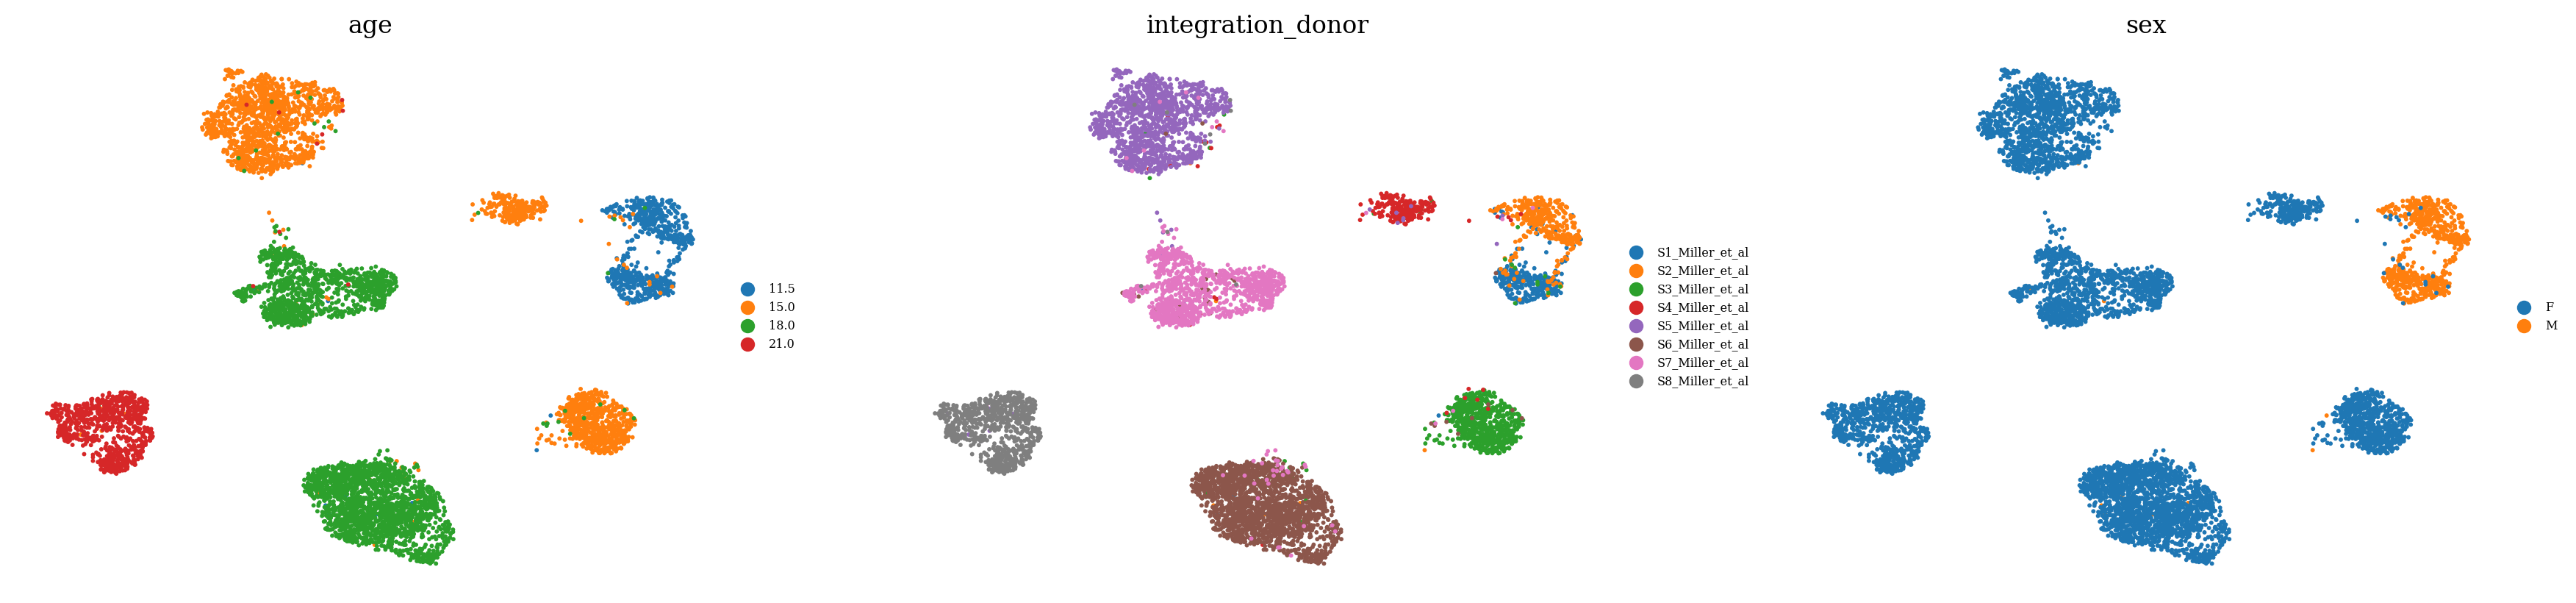

In [191]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [192]:
from tardis._disentanglementmanager import DisentanglementManager as DM

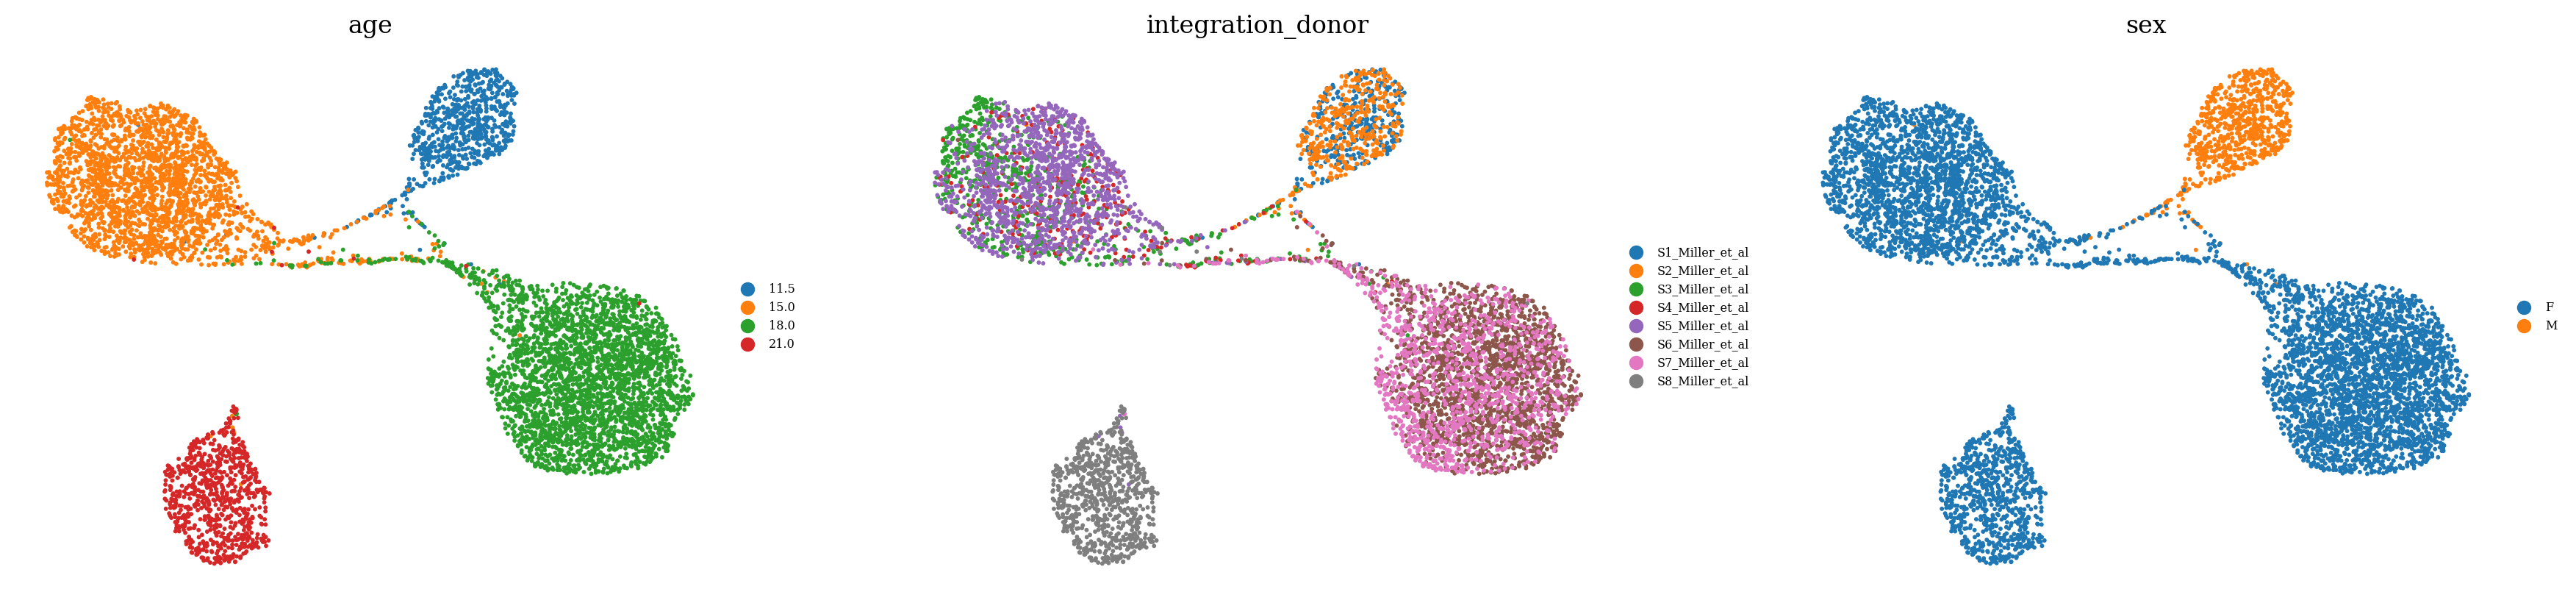

In [193]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent, n_neighbors = 30)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

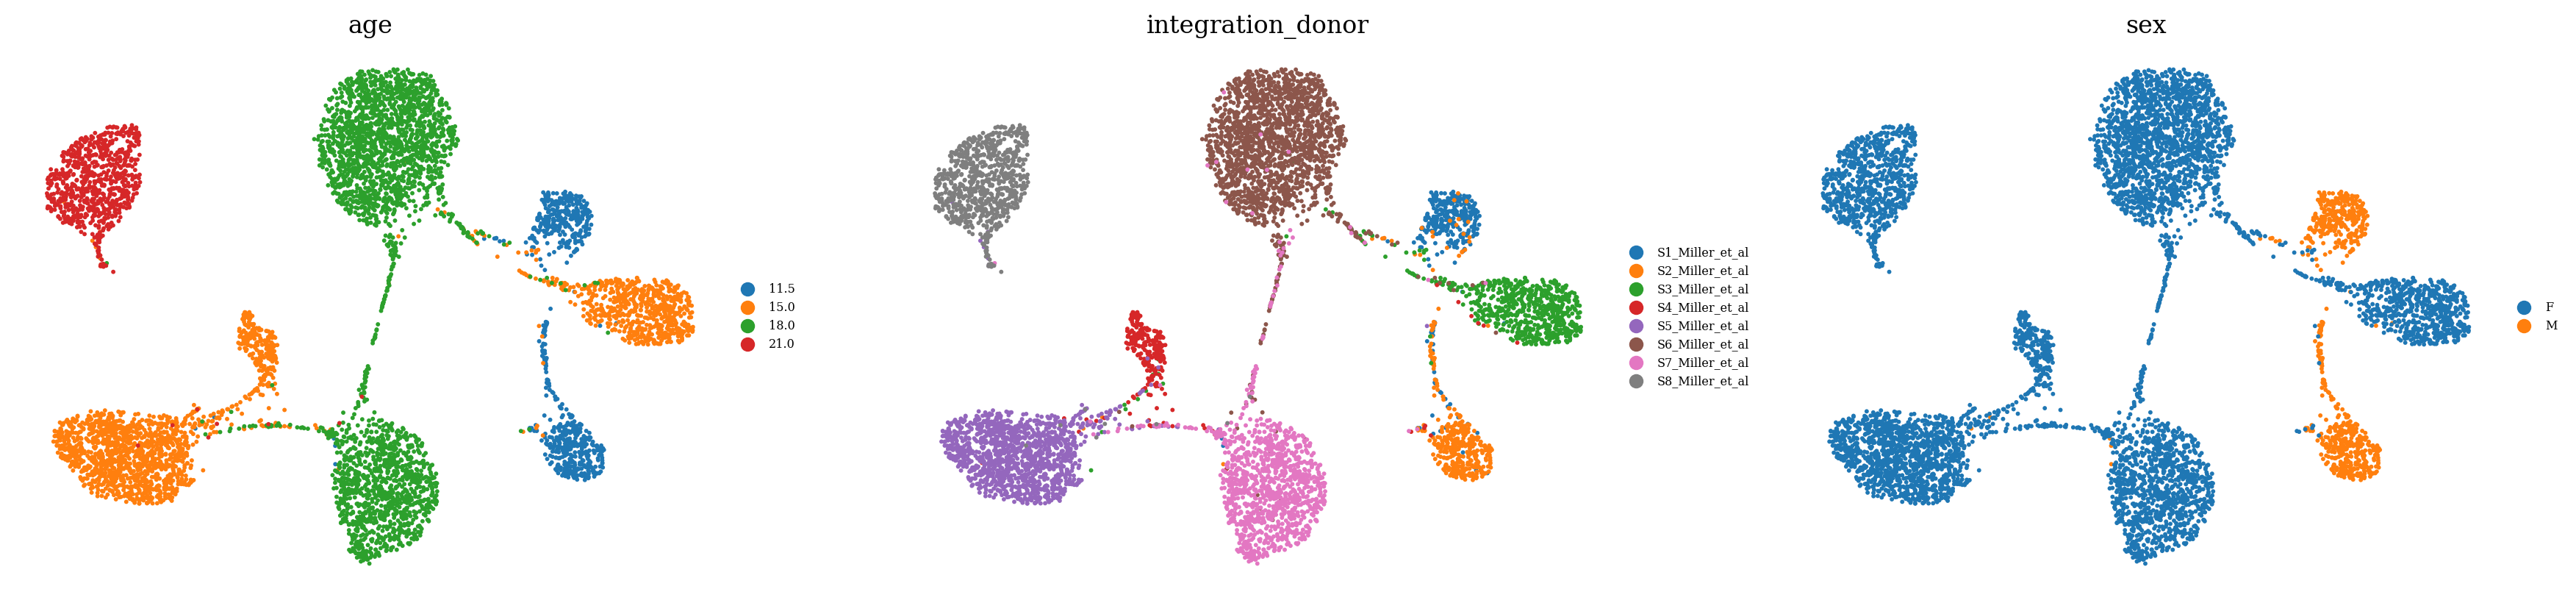

In [194]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key("integration_donor").reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent, n_neighbors = 30)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [195]:
adata_main = ad.read_h5ad(adata_file_path)
adata_main.obs["age"] = adata_main.obs["age"].astype("str").astype("category")
adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")

adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()

In [196]:
latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main)[:, DM.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata_main.obs.copy())
sc.pp.neighbors(latent_main, n_neighbors = 30)
sc.tl.umap(latent_main)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


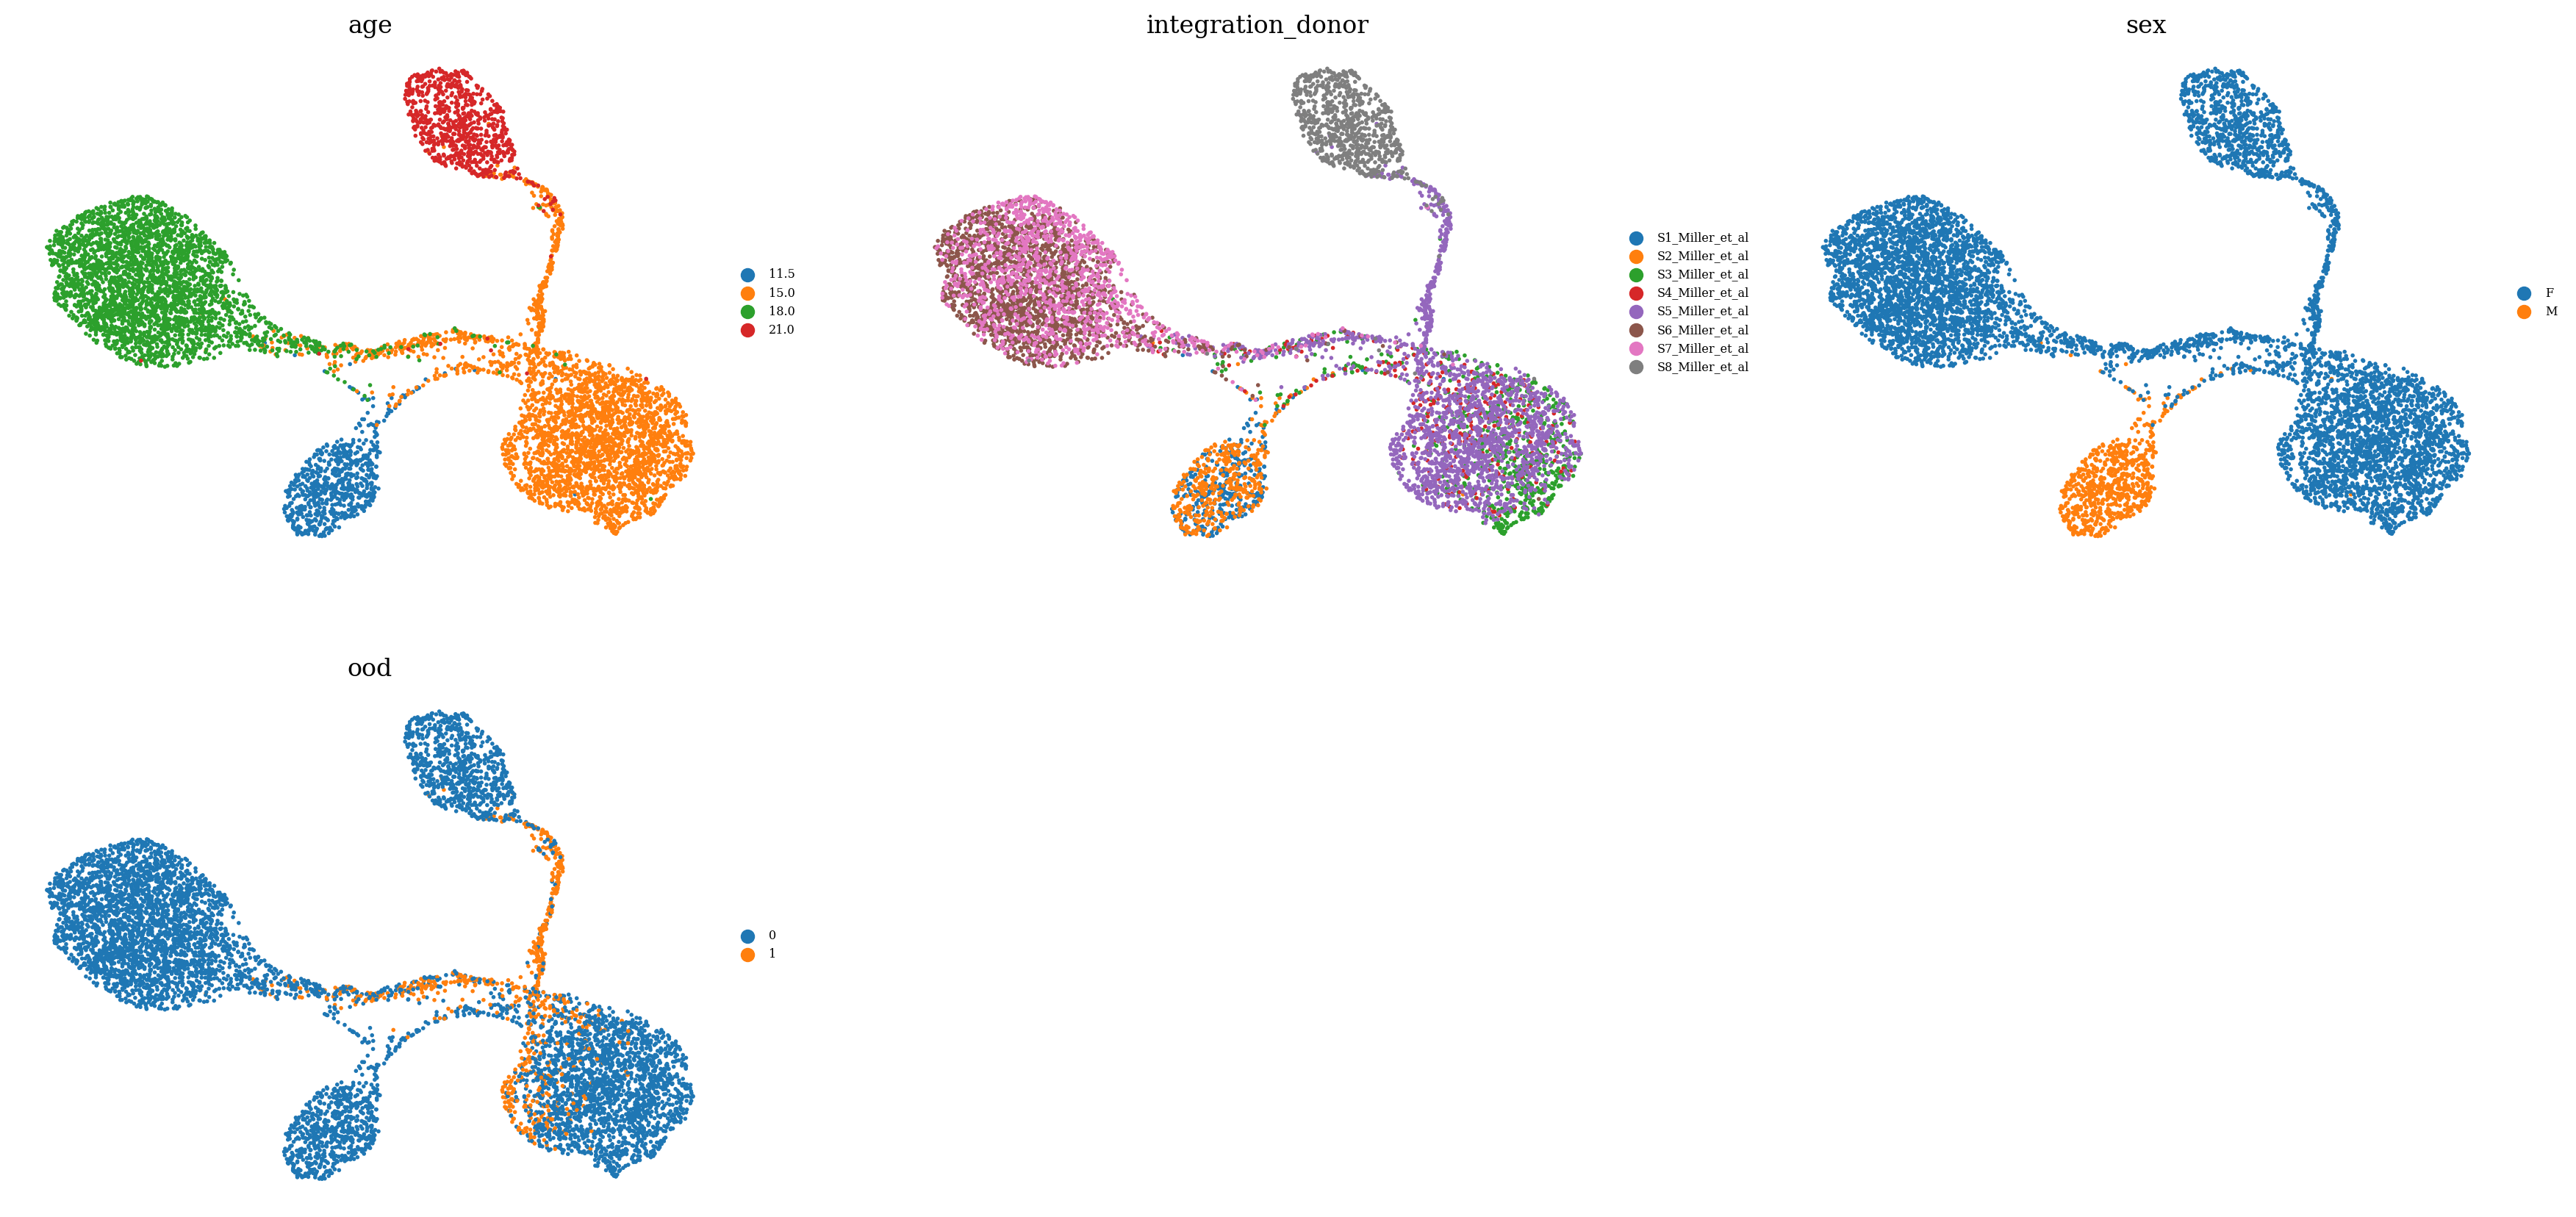

In [197]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_main, 
        color=["age", "integration_donor", "sex", "ood"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [198]:
latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood)[:, DM.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata_ood.obs.copy())
sc.pp.neighbors(latent_ood, n_neighbors = 30)
sc.tl.umap(latent_ood)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [199]:
latent_ood

AnnData object with n_obs × n_vars = 692 × 8
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse', 'n_genes', 'ood', '_scvi_batch', '_scvi_labels'
    uns: 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [200]:
label_transfer(latent, latent_ood, cluster_list=["age"], neighbors_count=30)

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [201]:
latent_ood.obs

sample_ID organ   age            cell_type sex  \
Miller_S3_ACTATCTAGAGACGAA        S3  Lung  15.0  Lung ciliated cells   F   
Miller_S3_CTCGAAACATGAACCT        S3  Lung  15.0  Lung ciliated cells   F   
Miller_S3_CTGATAGTCGGCGCAT        S3  Lung  15.0  Lung ciliated cells   F   
Miller_S4_AACACGTTCTGCAGTA        S4  Lung  15.0  Lung ciliated cells   F   
Miller_S4_AAGGAGCCACGCCAGT        S4  Lung  15.0  Lung ciliated cells   F   
...                              ...   ...   ...                  ...  ..   
Miller_S5_TTTCCTCTCACAACGT        S5  Lung  15.0  Lung ciliated cells   F   
Miller_S5_TTTCCTCTCATCATTC        S5  Lung  15.0  Lung ciliated cells   F   
Miller_S5_TTTGCGCGTGCGCTTG        S5  Lung  15.0  Lung ciliated cells   F   
Miller_S5_TTTGGTTGTGTCCTCT        S5  Lung  15.0  Lung ciliated cells   F   
Miller_S5_TTTGTCACAAGGACAC        S5  Lung  15.0  Lung ciliated cells   F   

                           sex_inferred concatenated_integration_covariates  \
Miller_S3_ACTATCTAGAGACGAA            F     S3_Miller_et_al_Cell_Fresh_3GEX   
Miller_S3_CTCGAAACATGAACCT            F     S3_Miller_et_al_Cell_Fresh_3GEX   
Miller_S3_CTGATAGTCGGCGCAT            F     S3_Miller_et_al_Cell_Fresh_3GEX   
Miller_S4_AACACGTTCTGCAGTA            F     S4_Miller_et_al_Cell_Fresh_3GEX   
Miller_S4_AAGGAGCCACGCCAGT            F     S4_Miller_et_al_Cell_Fresh_3GEX   
...                                 ...                                 ...   
Miller_S5_TTTCCTCTCACAACGT            F     S5_Miller_et_al_Cell_Fresh_3GEX   
Miller_S5_TTTCCTCTCATCATTC            F     S5_Miller_et_al_Cell_Fresh_3GEX   
Miller_S5_TTTGCGCGTGCGCTTG            F     S5_Miller_et_al_Cell_Fresh_3GEX   
Miller_S5_TTTGGTTGTGTCCTCT            F     S5_Miller_et_al_Cell_Fresh_3GEX   
Miller_S5_TTTGTCACAAGGACAC            F     S5_Miller_et_al_Cell_Fresh_3GEX   

                           integration_donor integration_biological_unit  \
Miller_S3_ACTATCTAGAGACGAA   S3_Miller_et_al                        Cell   
Miller_S3_CTCGAAACATGAACCT   S3_Miller_et_al                        Cell   
Miller_S3_CTGATAGTCGGCGCAT   S3_Miller_et_al                        Cell   
Miller_S4_AACACGTTCTGCAGTA   S4_Miller_et_al                        Cell   
Miller_S4_AAGGAGCCACGCCAGT   S4_Miller_et_al                        Cell   
...                                      ...                         ...   
Miller_S5_TTTCCTCTCACAACGT   S5_Miller_et_al                        Cell   
Miller_S5_TTTCCTCTCATCATTC   S5_Miller_et_al                        Cell   
Miller_S5_TTTGCGCGTGCGCTTG   S5_Miller_et_al                        Cell   
Miller_S5_TTTGGTTGTGTCCTCT   S5_Miller_et_al                        Cell   
Miller_S5_TTTGTCACAAGGACAC   S5_Miller_et_al                        Cell   

                           integration_sample_status  \
Miller_S3_ACTATCTAGAGACGAA                     Fresh   
Miller_S3_CTCGAAACATGAACCT                     Fresh   
Miller_S3_CTGATAGTCGGCGCAT                     Fresh   
Miller_S4_AACACGTTCTGCAGTA                     Fresh   
Miller_S4_AAGGAGCCACGCCAGT                     Fresh   
...                                              ...   
Miller_S5_TTTCCTCTCACAACGT                     Fresh   
Miller_S5_TTTCCTCTCATCATTC                     Fresh   
Miller_S5_TTTGCGCGTGCGCTTG                     Fresh   
Miller_S5_TTTGGTTGTGTCCTCT                     Fresh   
Miller_S5_TTTGTCACAAGGACAC                     Fresh   

                           integration_library_platform_coarse  n_genes ood  \
Miller_S3_ACTATCTAGAGACGAA                                3GEX      401   1   
Miller_S3_CTCGAAACATGAACCT                                3GEX      356   1   
Miller_S3_CTGATAGTCGGCGCAT                                3GEX      644   1   
Miller_S4_AACACGTTCTGCAGTA                                3GEX      238   1   
Miller_S4_AAGGAGCCACGCCAGT                                3GEX      197   1   
...                                                        ...      ...  ..   
Miller_S5_TTTC

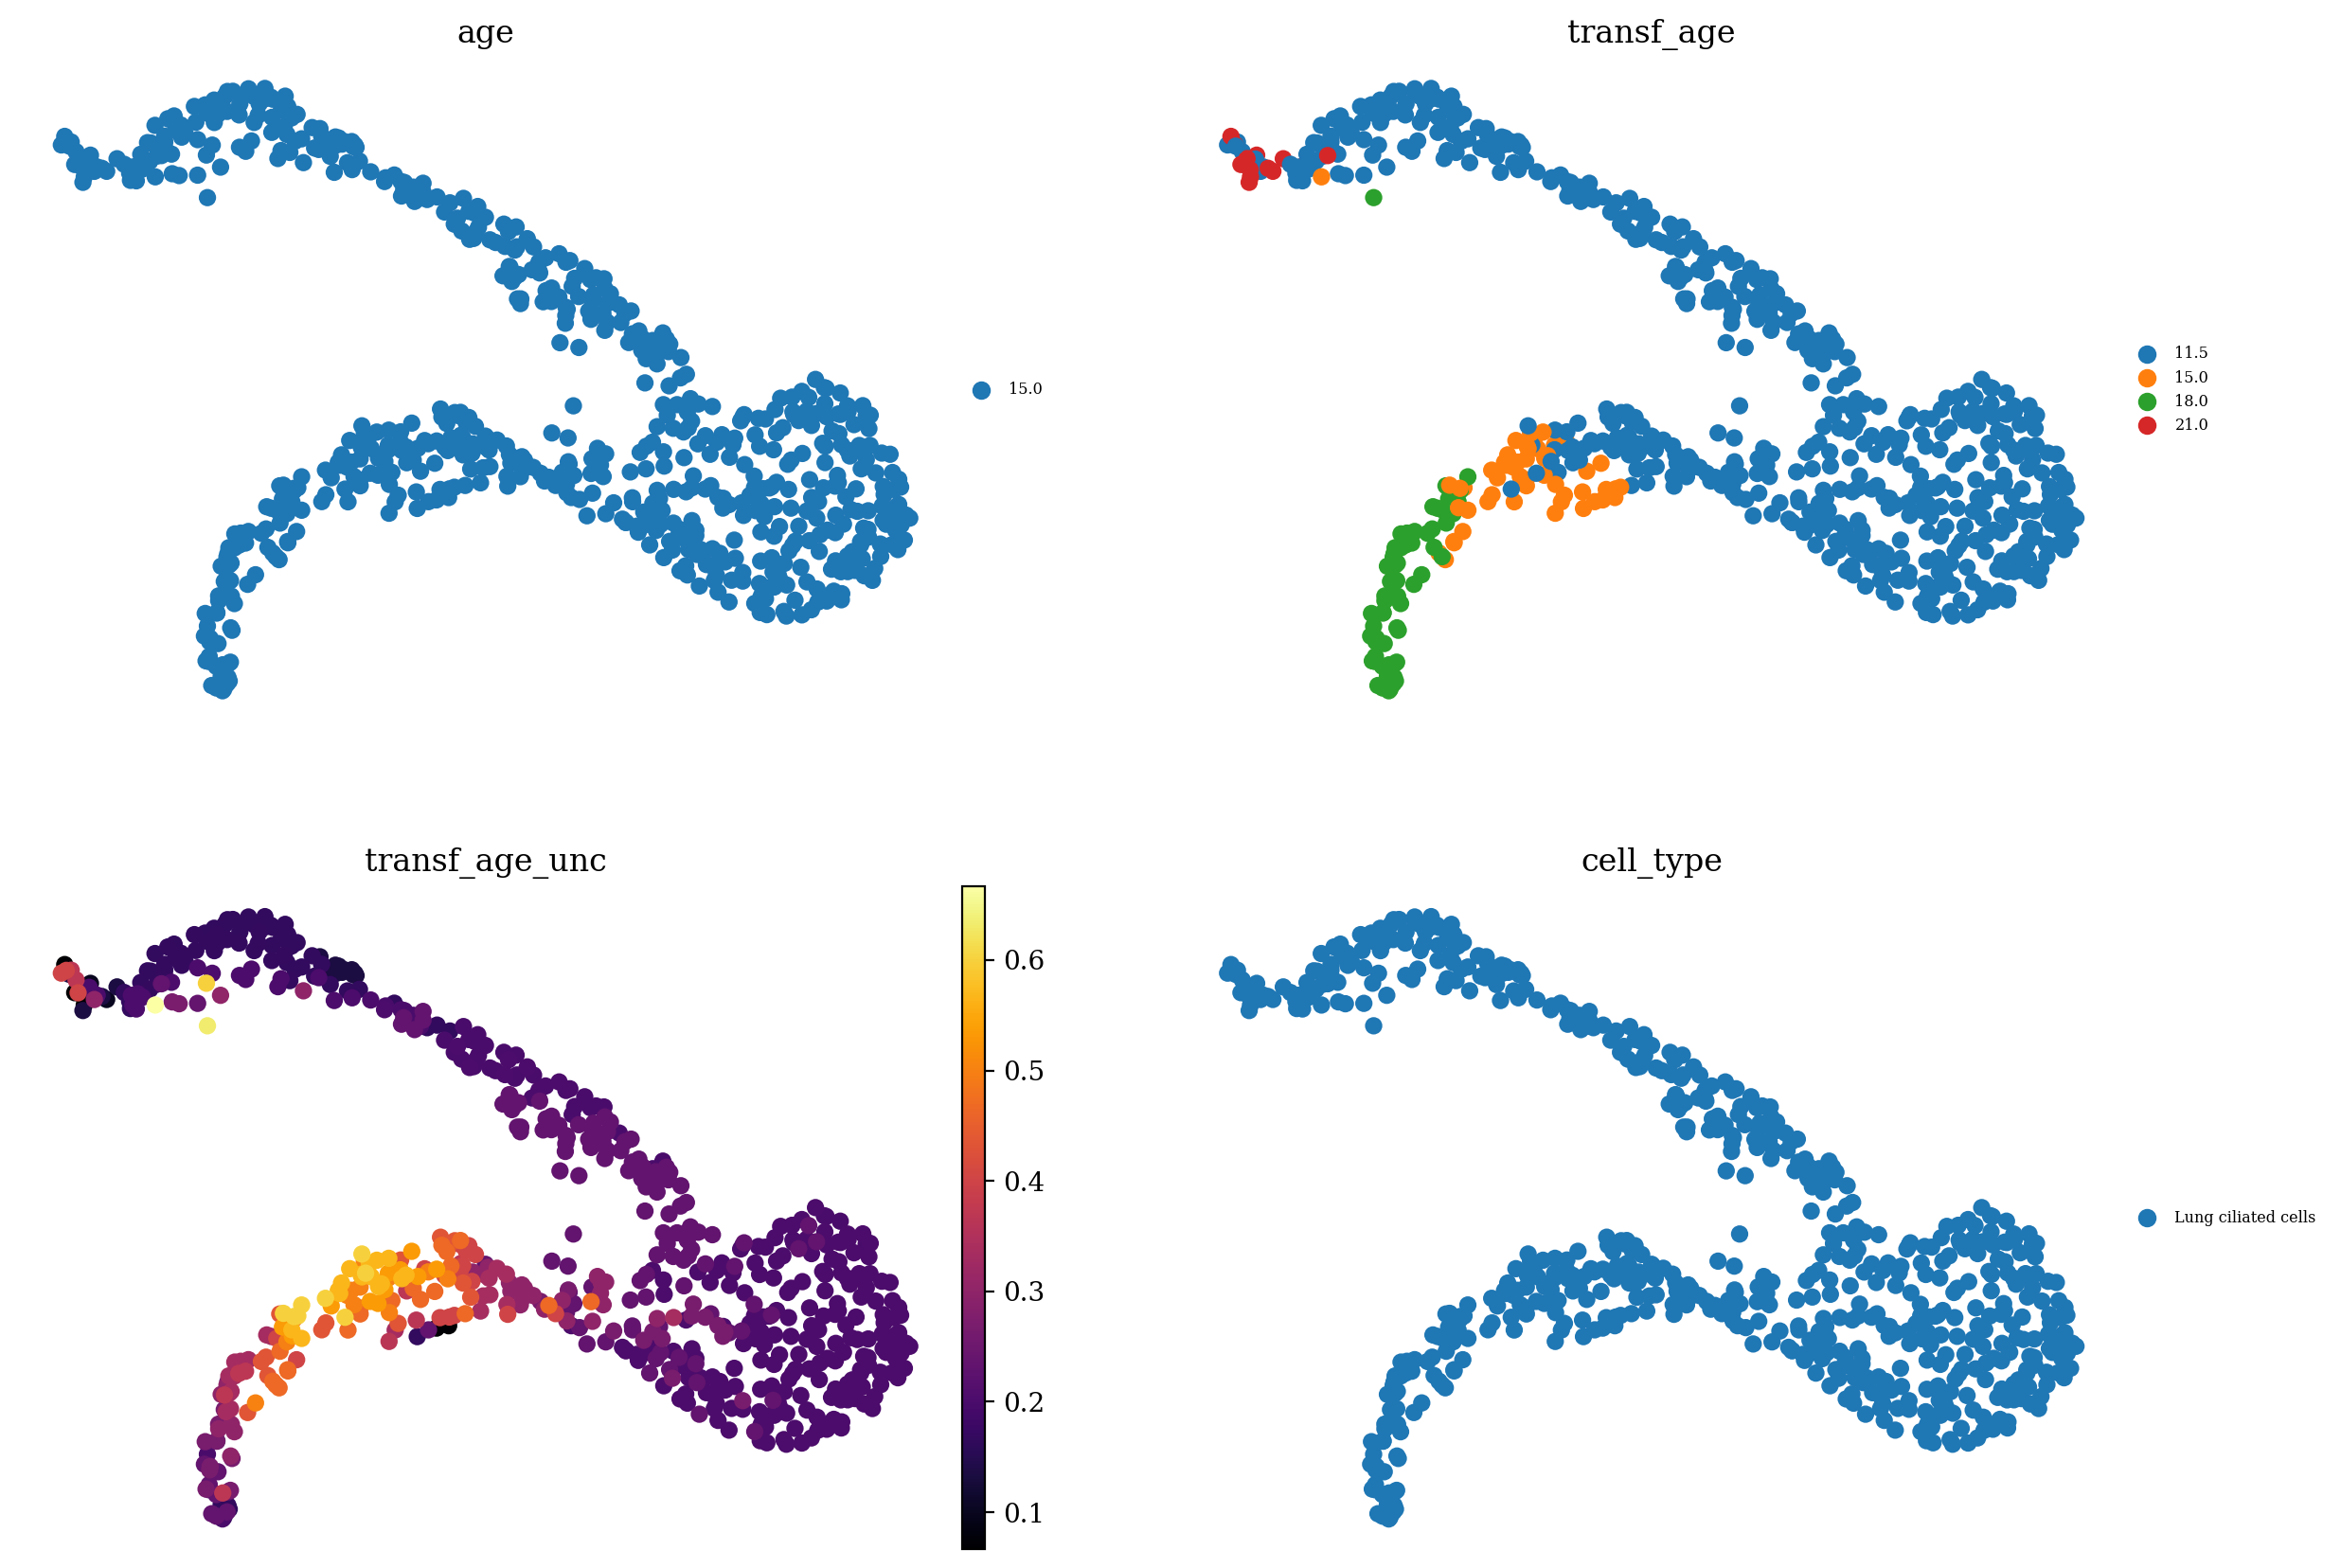

In [202]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_ood, 
        color=["age", "transf_age", "transf_age_unc", "cell_type"], 
        ncols=2,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [203]:
k = "age"
predicted = latent_ood.obs[f"transf_{k}"].astype(str).values
true = latent_ood.obs[k].astype(str).values

In [204]:
import sklearn

metrics = {}
metrics['accuracy'] = sklearn.metrics.accuracy_score(true, predicted)
metrics['precision_macro'] = sklearn.metrics.precision_score(true, predicted, average='macro', zero_division=0)
metrics['recall_macro'] = sklearn.metrics.recall_score(true, predicted, average='macro', zero_division=0)
metrics['f1_score_macro'] = sklearn.metrics.f1_score(true, predicted, average='macro', zero_division=0)
metrics['precision_micro'] = sklearn.metrics.precision_score(true, predicted, average='micro', zero_division=0)
metrics['recall_micro'] = sklearn.metrics.recall_score(true, predicted, average='micro', zero_division=0)
metrics['f1_score_micro'] = sklearn.metrics.f1_score(true, predicted, average='micro', zero_division=0)
metrics['precision_weighted'] = sklearn.metrics.precision_score(true, predicted, average='weighted', zero_division=0)
metrics['recall_weighted'] = sklearn.metrics.recall_score(true, predicted, average='weighted', zero_division=0)
metrics['f1_score_weighted'] = sklearn.metrics.f1_score(true, predicted, average='weighted', zero_division=0)
metrics['confusion_matrix'] = sklearn.metrics.confusion_matrix(true, predicted)
metrics

{'accuracy': 0.07514450867052024,
 'precision_macro': 0.25,
 'recall_macro': 0.01878612716763006,
 'f1_score_macro': 0.03494623655913979,
 'precision_micro': 0.07514450867052024,
 'recall_micro': 0.07514450867052024,
 'f1_score_micro': 0.07514450867052024,
 'precision_weighted': 1.0,
 'recall_weighted': 0.07514450867052024,
 'f1_score_weighted': 0.13978494623655915,
 'confusion_matrix': array([[  0,   0,   0,   0],
        [563,  52,  64,  13],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0]])}

In [205]:
np.sum(latent.obs['age'] == '15.0')/len(latent)

0.3324892000595859